In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


# 얼굴 인식

copy from : https://github.com/santhalakshminarayana/face-recognition/blob/master/Face_Recognition.ipynb

아티클 : https://medium.com/analytics-vidhya/face-recognition-with-vgg-face-in-keras-96e6bc1951d5


얼굴 부분 추출과, 추출된 얼굴의 분류 2단계로 진행됨.

얼굴 추출은 이미 학습된 모델을 가져와서 추출하고, 추출된 부분을 별개의 파일로 저장.

별개의 파일로 저장된 얼굴 영상을 VGGFace 모델을 가져와서 feature를 추출함.

이렇게 추출한 feature를 입력으로 얼굴 분류 모델을 학습한다.




# 데이터 준비

In [2]:
!pwd

/content


colab의 default 홈 디렉토리로 이동

In [3]:
%cd /content

/content


혹시 이전의 흔적이 있으면 깔끔히 지우고

In [4]:
%%shell
rm -rf __MACOSX
rm -rf face_data.zip
rm -rf face_data

## 데이터 준비

아래와 같이 데이터를 준비한다.
반드시 확장가 'jpg'이어야 한다.

<br> face_data.jpg로 묶어서 구글드라이브의 tmp 폴더에 가져다 놓는다.

```
face_data/
  Images/
    jobs_1.jpg
    jobs_2.jpg
    ...
    faker_1.jpg
    faker_2.jpg
    ...
    iu_1.jpg
    iu_2.jpg
  Test_images/
    jobs_11.jpg
    jobs_12.jpg
    ...
    faker_11.jpg
    faker_12.jpg
    ...
    iu_11.jpg
    iu_12.jpg
```



구글 드라이브 마운트

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


혹시 기존에 파일들이 있으면 깔금히 지우고 시작

In [6]:
%%shell
rm -rf face_data.zip
rm -rf face_data

구글 드라이브에서 colab 으로 파일 카피

In [7]:
!cp '/content/drive/My Drive/tmp/face_data.zip' ./

압축 풀기

In [8]:
!unzip face_data.zip

Archive:  face_data.zip
   creating: face_data/face_data/
   creating: face_data/face_data/Images/
  inflating: face_data/face_data/Images/dongsuk_1.jpg  
  inflating: face_data/face_data/Images/dongsuk_2.jpg  
  inflating: face_data/face_data/Images/dongsuk_3.jpg  
  inflating: face_data/face_data/Images/dongsuk_4.jpg  
  inflating: face_data/face_data/Images/dongsuk_5.jpg  
  inflating: face_data/face_data/Images/dongsuk_6.jpg  
  inflating: face_data/face_data/Images/dongsuk_7.jpg  
  inflating: face_data/face_data/Images/dongsuk_8.jpg  
  inflating: face_data/face_data/Images/faker_1.jpg  
  inflating: face_data/face_data/Images/faker_10.jpg  
  inflating: face_data/face_data/Images/faker_11.jpg  
  inflating: face_data/face_data/Images/faker_15.jpg  
  inflating: face_data/face_data/Images/faker_16.jpg  
  inflating: face_data/face_data/Images/faker_18.jpg  
  inflating: face_data/face_data/Images/faker_2.jpg  
  inflating: face_data/face_data/Images/faker_21.jpg  
  inflating: fa

이미를 읽을 위치를 설정


폴더 Images, Test_images가 있는 위치를 path로 설정

In [9]:
WORKING_PATH='/content/face_data/face_data'

폴더 Images, Test_images가 있는 위치로 이동

In [10]:
%cd $WORKING_PATH

/content/face_data/face_data


Images 폴더 안의 영상 파일이름을 구한다.

In [11]:
import os
import glob

TARGET_FOLDER_NAME = "Images"

image_path_names=[]
person_names=set()
for file_name in glob.glob(WORKING_PATH+'/'+TARGET_FOLDER_NAME+'/*_[1-9]*.jpg'):
  image_path_names.append(file_name)
  person_names.add(image_path_names[-1].split('/')[-1].split('_')[0])

이미지 파일 갯수

In [12]:
len(image_path_names)

48

파일 이름들 보기

In [13]:
print(image_path_names)

['/content/face_data/face_data/Images/jobs_24.jpg', '/content/face_data/face_data/Images/dongsuk_1.jpg', '/content/face_data/face_data/Images/dongsuk_5.jpg', '/content/face_data/face_data/Images/iu_10.jpg', '/content/face_data/face_data/Images/dongsuk_8.jpg', '/content/face_data/face_data/Images/faker_10.jpg', '/content/face_data/face_data/Images/iu_13.jpg', '/content/face_data/face_data/Images/dongsuk_2.jpg', '/content/face_data/face_data/Images/faker_11.jpg', '/content/face_data/face_data/Images/jobs_17.jpg', '/content/face_data/face_data/Images/jobs_5.jpg', '/content/face_data/face_data/Images/faker_2.jpg', '/content/face_data/face_data/Images/dongsuk_7.jpg', '/content/face_data/face_data/Images/faker_24.jpg', '/content/face_data/face_data/Images/iu_16.jpg', '/content/face_data/face_data/Images/faker_9.jpg', '/content/face_data/face_data/Images/iu_17.jpg', '/content/face_data/face_data/Images/faker_16.jpg', '/content/face_data/face_data/Images/faker_8.jpg', '/content/face_data/face_

사람 이름 보기

In [14]:
print(person_names)

{'jobs', 'faker', 'dongsuk', 'iu'}


# 얼굴 분류를 위한 얼굴부분 데이터 만들기

얼굴 부분 탐지하여 crop한다.


dlib의 face detector를 사용

face detector 모델을 다운로드

In [15]:
# Download Dlib CNN face detector
!wget http://dlib.net/files/mmod_human_face_detector.dat.bz2

--2020-08-21 14:47:30--  http://dlib.net/files/mmod_human_face_detector.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 694709 (678K)
Saving to: ‘mmod_human_face_detector.dat.bz2’

mmod_human_face_det 100%[===================>] 678.43K   651KB/s    in 1.0s    

2020-08-21 14:47:32 (651 KB/s) - ‘mmod_human_face_detector.dat.bz2’ saved [694709/694709]



압축 풀기

In [16]:
!bzip2 -dk mmod_human_face_detector.dat.bz2

압축 파일은 지우고

In [17]:
!rm mmod_human_face_detector.dat.bz2

## FaceDetector 로딩

In [18]:
import cv2
import matplotlib.pyplot as plt
import dlib

## Images 폴더 파일들 crop

Images 폴더의 파일들을 읽어 Images_crop에 생성

모델 로딩

In [19]:
dnnFaceDetector=dlib.cnn_face_detection_model_v1("mmod_human_face_detector.dat")

저장될 폴더 이름

In [20]:
CROP_OUTPUT_FOLDER_NAME = 'Images_crop'

crop되어 저장될 폴더 생성

In [22]:
 os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME)

각 카테고리 별 폴더 생성

In [23]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+person+'/')

In [25]:
!ls -al $CROP_OUTPUT_FOLDER_NAME

total 24
drwxr-xr-x 6 root root 4096 Aug 21 14:48 .
drwxr-xr-x 5 root root 4096 Aug 21 14:48 ..
drwxr-xr-x 2 root root 4096 Aug 21 14:48 dongsuk
drwxr-xr-x 2 root root 4096 Aug 21 14:48 faker
drwxr-xr-x 2 root root 4096 Aug 21 14:48 iu
drwxr-xr-x 2 root root 4096 Aug 21 14:48 jobs


In [27]:
TARGET_IMAGE_PATH_NAMES = image_path_names

for file_name in TARGET_IMAGE_PATH_NAMES:

  # 이미지 읽기
  img=cv2.imread(file_name)

  # 모델의 입력에 맞게 변환
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 박스 검출
  rects=dnnFaceDetector(gray,1)

  # 검출된 박스에서 left, top, right, bottom 값 구하기
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue

  # width와 height 구하기
  width=right-left
  height=bottom-top

  # 이미지 crop
  img_crop=img[top:top+height,left:left+width]

  # 저장할 파일 이름 만들기
  img_path=WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  # crop한 이미지를 파일로 쓰기
  cv2.imwrite(img_path,img_crop)

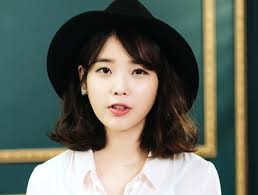

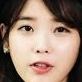

In [28]:
from IPython.display import Image
display(Image('Images/iu_10.jpg'))
display(Image('Images_crop/iu/iu_10.jpg'))

## Test_Image 파일들 crop

Test_Images의 파일들을 읽어 Test_Images_crop에 생성

Images 폴더 안의 영상 파일이름을 구한다.

In [29]:
import os
import glob

TARGET_FOLDER_NAME = "Test_images"

test_image_path_names=[]
for file_name in glob.glob(WORKING_PATH+'/'+TARGET_FOLDER_NAME+'/*_[1-9]*.jpg'):
  test_image_path_names.append(file_name)

이미지 파일 갯수

In [30]:
len(test_image_path_names)

24

파일 이름들 보기

In [31]:
print(test_image_path_names)

['/content/face_data/face_data/Test_images/jobs_31.jpg', '/content/face_data/face_data/Test_images/iu_34.jpg', '/content/face_data/face_data/Test_images/faker_28.jpg', '/content/face_data/face_data/Test_images/iu_25.jpg', '/content/face_data/face_data/Test_images/dongsuk_9.jpg', '/content/face_data/face_data/Test_images/jobs_32.jpg', '/content/face_data/face_data/Test_images/jobs_28.jpg', '/content/face_data/face_data/Test_images/faker_32.jpg', '/content/face_data/face_data/Test_images/iu_24.jpg', '/content/face_data/face_data/Test_images/jobs_36.jpg', '/content/face_data/face_data/Test_images/faker_27.jpg', '/content/face_data/face_data/Test_images/faker_29.jpg', '/content/face_data/face_data/Test_images/iu_27.jpg', '/content/face_data/face_data/Test_images/faker_25.jpg', '/content/face_data/face_data/Test_images/faker_33.jpg', '/content/face_data/face_data/Test_images/iu_23.jpg', '/content/face_data/face_data/Test_images/jobs_30.jpg', '/content/face_data/face_data/Test_images/dongsuk

In [32]:
CROP_OUTPUT_FOLDER_NAME = 'Test_Images_crop'

crop되어 저장될 폴더 생성

In [33]:
os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME)

각 카테고리 별 폴더 생성

In [34]:
# For each person create a separate folder
for person in person_names:
  os.mkdir(WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+person+'/')

In [35]:
!ls -al $CROP_OUTPUT_FOLDER_NAME

total 24
drwxr-xr-x 6 root root 4096 Aug 21 14:50 .
drwxr-xr-x 6 root root 4096 Aug 21 14:50 ..
drwxr-xr-x 2 root root 4096 Aug 21 14:50 dongsuk
drwxr-xr-x 2 root root 4096 Aug 21 14:50 faker
drwxr-xr-x 2 root root 4096 Aug 21 14:50 iu
drwxr-xr-x 2 root root 4096 Aug 21 14:50 jobs


In [36]:
TARGET_IMAGE_PATH_NAMES = test_image_path_names

for file_name in TARGET_IMAGE_PATH_NAMES:

  # 이미지 읽기
  img=cv2.imread(file_name)

  # 모델의 입력에 맞게 변환
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 박스 검출
  rects=dnnFaceDetector(gray,1)

  # 검출된 박스에서 left, top, right, bottom 값 구하기
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
  if right==0: continue

  # width와 height 구하기
  width=right-left
  height=bottom-top

  # 이미지 crop
  img_crop=img[top:top+height,left:left+width]

  # 저장할 파일 이름 만들기
  img_path=WORKING_PATH+'/'+CROP_OUTPUT_FOLDER_NAME+'/'+file_name.split('/')[-1].split('_')[0]+'/'+file_name.split('/')[-1]
  # crop한 이미지를 파일로 쓰기
  cv2.imwrite(img_path,img_crop)

이제 다음과 같은 구조의 폴더가 생성되었다.
Images_crop, Test_Images_crop 밑에는 얼굴부분만 crop된 이미지들이 생성되어 있다.

```
Directory structure :
|--Images /
|  |-- (60 images)
|
|--Images_crop /
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|
|--Test_Images / 
|  |-- .. / (18 images)
|
|--Test_Images_crop / 
|  |--faker
|     |--(images)
|  |--iu / 
|     |--(images)
|  |--jobs / 
|     |--(imgaes)
|--mmod_human_face_detector.dat
```

# VGGFace 모델 로딩

얼굴 피쳐 추출을 위해 VGGFace를 사용한다.

https://github.com/rcmalli/keras-vggface

In [37]:
!pip install keras_vggface

In [38]:
from keras_vggface.vggface import VGGFace

vgg_face_model = VGGFace(include_top=False, input_shape=(224, 224, 3))

Using TensorFlow backend.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.

58916864/58909280 [==============================] - 2s 0us/step


# 학습 데이터 로딩

In [61]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D, Input, Flatten
from tensorflow.keras.layers import Dense,Dropout,Softmax,Flatten,Activation,BatchNormalization
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.imagenet_utils import preprocess_input
import tensorflow.keras.backend as K

In [49]:
#Prepare Training Data
x_train=[]
y_train=[]
person_folders=os.listdir(WORKING_PATH+'/Images_crop/')
person_rep=dict()
for i,person in enumerate(person_folders):
  person_rep[i]=person
  image_names=os.listdir('Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(WORKING_PATH+'/Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encoded = vgg_face_model.predict(img)  # 얼굴의 feature를 추출한다.
    x_train.append(np.squeeze(K.eval(img_encoded)).tolist())
    y_train.append(i)

In [51]:
x_train=np.array(x_train)
y_train=np.array(y_train)

In [53]:
#Prepare Test Data
x_test=[]
y_test=[]
person_folders=os.listdir(WORKING_PATH+'/Test_Images_crop/')
for i,person in enumerate(person_folders):
  image_names=os.listdir('Test_Images_crop/'+person+'/')
  for image_name in image_names:
    img=load_img(WORKING_PATH+'/Test_Images_crop/'+person+'/'+image_name,target_size=(224,224))
    img=img_to_array(img)
    img=np.expand_dims(img,axis=0)
    img=preprocess_input(img)
    img_encoded = vgg_face_model.predict(img)  # 얼굴의 feature를 추출한다.
    x_test.append(np.squeeze(K.eval(img_encoded)).tolist())
    y_test.append(i)

In [54]:
x_test=np.array(x_test)
y_test=np.array(y_test)

In [55]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(46, 7, 7, 512)
(46,)
(24, 7, 7, 512)
(24,)


In [59]:
print(x_train.shape)

(46, 7, 7, 512)


# Face 분류 모델 정의

In [64]:
classifier_model = Sequential()
classifier_model.add(Input(x_train.shape[1:]))
classifier_model.add(Flatten())
lassifier_model.add(Dense(units=100, kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.3))
classifier_model.add(Dense(units=10,kernel_initializer='glorot_uniform'))
classifier_model.add(BatchNormalization())
classifier_model.add(Activation('tanh'))
classifier_model.add(Dropout(0.2))
classifier_model.add(Dense(units=6,kernel_initializer='he_uniform'))
classifier_model.add(Activation('softmax'))


# 분류 모델 학습

In [65]:
classifier_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer='nadam',metrics=['accuracy'])

classifier_model.fit(x_train,y_train,epochs=100,validation_data=(x_test,y_test))

Train on 46 samples, validate on 24 samples
Epoch 1/100
46/46 [==============================] - 1s 15ms/sample - loss: 1.7418 - acc: 0.3043 - val_loss: 0.3310 - val_acc: 0.9583
Epoch 2/100
46/46 [==============================] - 0s 746us/sample - loss: 0.5093 - acc: 0.9565 - val_loss: 0.2629 - val_acc: 0.9583
Epoch 3/100
46/46 [==============================] - 0s 744us/sample - loss: 0.3936 - acc: 0.9783 - val_loss: 0.2265 - val_acc: 0.9583
Epoch 4/100
46/46 [==============================] - 0s 861us/sample - loss: 0.3129 - acc: 1.0000 - val_loss: 0.2119 - val_acc: 0.9583
Epoch 5/100
46/46 [==============================] - 0s 714us/sample - loss: 0.3149 - acc: 1.0000 - val_loss: 0.2177 - val_acc: 0.9583
Epoch 6/100
46/46 [==============================] - 0s 739us/sample - loss: 0.3055 - acc: 1.0000 - val_loss: 0.2082 - val_acc: 0.9583
Epoch 7/100
46/46 [==============================] - 0s 772us/sample - loss: 0.3341 - acc: 1.0000 - val_loss: 0.1961 - val_acc: 0.9583
Epoch 8/100


# 얼굴 인식 실행

In [66]:
def plot(img):
  plt.figure(figsize=(8,4))
  plt.imshow(img[:,:,::-1])
  plt.show()

In [67]:
os.mkdir(WORKING_PATH+'/Predictions')

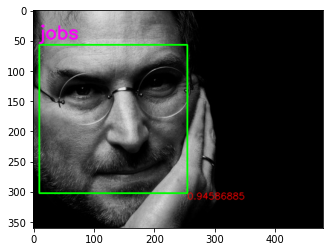

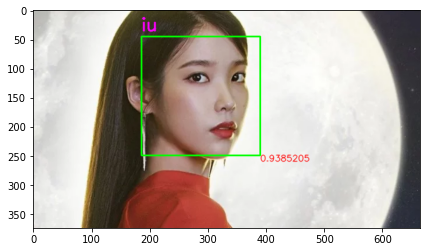

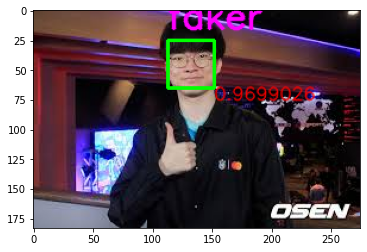

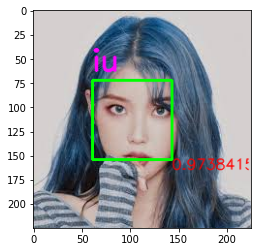

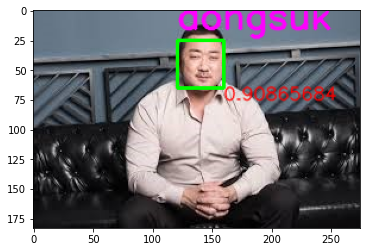

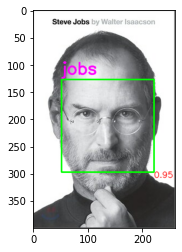

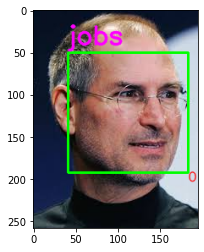

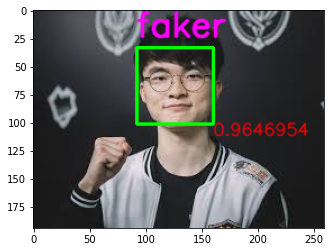

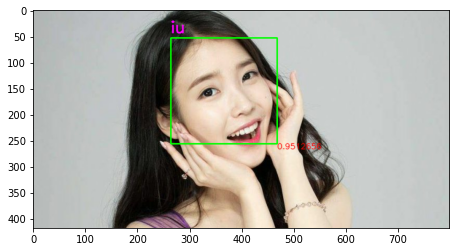

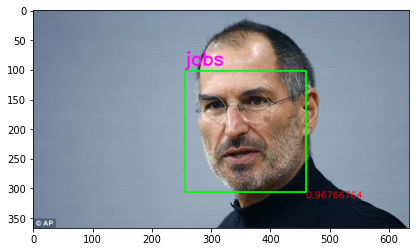

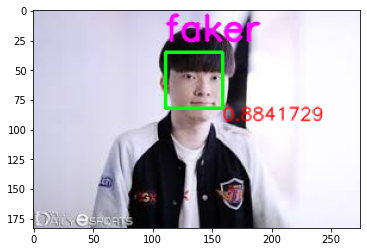

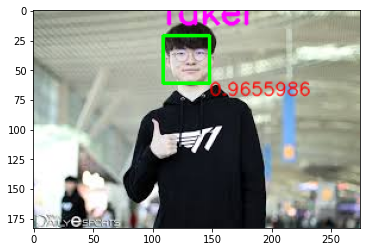

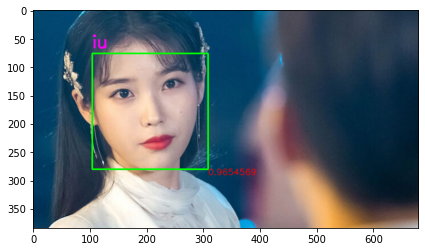

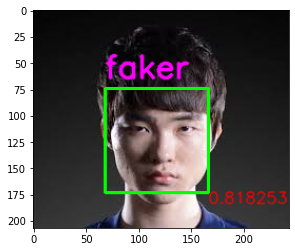

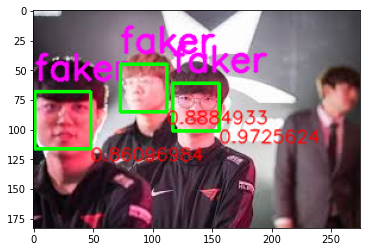

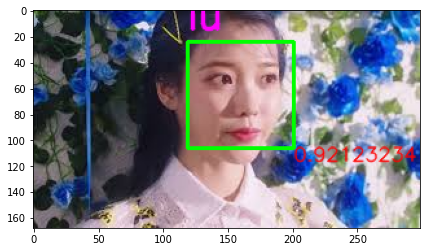

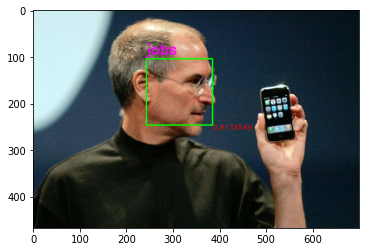

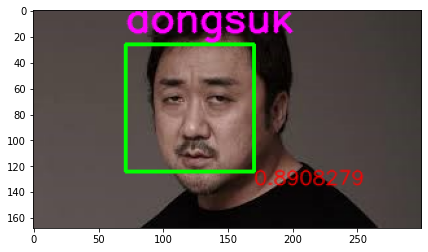

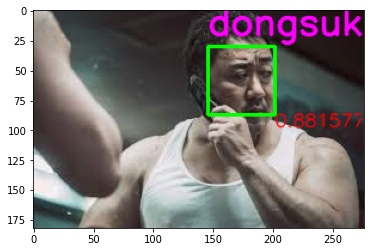

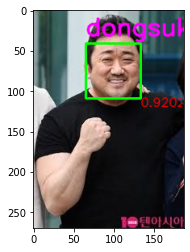

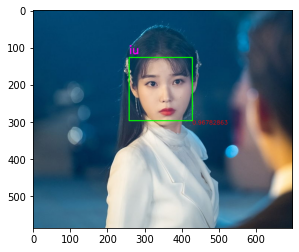

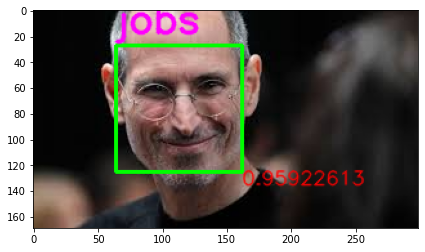

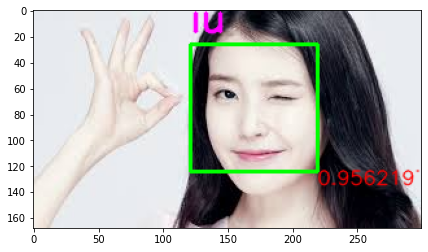

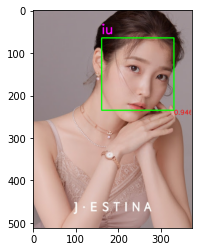

In [69]:
for img_name in os.listdir(WORKING_PATH+'/Test_images/'):
  if img_name=='crop_img.jpg':
    continue
  # Load Image
  img=cv2.imread(WORKING_PATH+'/Test_images/'+img_name)
  gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # 얼굴 탐지
  rects=dnnFaceDetector(gray,1)
  left,top,right,bottom=0,0,0,0
  for (i,rect) in enumerate(rects):
    # Extract Each Face
    left=rect.rect.left() #x1
    top=rect.rect.top() #y1
    right=rect.rect.right() #x2
    bottom=rect.rect.bottom() #y2
    width=right-left
    height=bottom-top
    img_crop=img[top:top+height,left:left+width]
    cv2.imwrite(WORKING_PATH+'/Test_images/crop_img.jpg',img_crop)
    
    # 얼굴 영역 crop
    crop_img=load_img(WORKING_PATH+'/Test_images/crop_img.jpg',target_size=(224,224))
    crop_img=img_to_array(crop_img)
    crop_img=np.expand_dims(crop_img,axis=0)
    crop_img=preprocess_input(crop_img)
    img_encode=vgg_face_model.predict(crop_img)

    # 얼굴 영역 인식
    embed=K.eval(img_encode)
    person=classifier_model.predict(embed)
    name=person_rep[np.argmax(person)]
    os.remove(WORKING_PATH+'/Test_images/crop_img.jpg')
    cv2.rectangle(img,(left,top),(right,bottom),(0,255,0), 2)
    img=cv2.putText(img,name,(left,top-10),cv2.FONT_HERSHEY_SIMPLEX,1,(255,0,255),2,cv2.LINE_AA)
    img=cv2.putText(img,str(np.max(person)),(right,bottom+10),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255),1,cv2.LINE_AA)
  # Save images with bounding box,name and accuracy 
  cv2.imwrite(WORKING_PATH+'/Predictions/'+img_name,img)
  plot(img)